<hr style="border:1px solid gray">

## phase retrieval algorithm
created: **10/07/2023**; last edited: **24/07/2023**

[rafael.celestre@esrf.eu](mailto:rafael.celestre@esrf.eu)

<hr style="border:1px solid gray">

In [1]:
# checking we are using the correct python:
import sys

print(sys.executable)
print(sys.version)
sys.path.insert(0, '../srwpy/')

# %matplotlib notebook
%matplotlib inline

import timeit
from copy import copy
import numpy as np
import pickle
from scipy.interpolate import RectBivariateSpline, interp1d
from scipy.signal import peak_widths

from PIL import Image
import glob

from skimage.restoration import unwrap_phase

import xraylib as xl                         # get xraylib: https://anaconda.org/conda-forge/xraylib

try:
    from srwlib import *                     # uses SRW repository
    from uti_plot import *
    print('SRW distribution of SRW')
except:
    from oasys_srw.srwlib import *           # get oasys_srw: https://github.com/oasys-kit/OASYS1-srwpy
    from oasys_srw.uti_plot import *
    print('OASYS distribution of SRW')
    
import barc4plots.barc4plots as b4pt         # get barc4plots: https://gitlab.esrf.fr/celestre/barc4plots


/home/esrf/celestre/miniconda/envs/xog/bin/python
3.10.11 (main, May 16 2023, 00:28:57) [GCC 11.2.0]
SRW distribution of SRW


<hr style="border:5px solid orange">

### Definition of the beamline:

X-ray beam (parabolic beam with Gaussian amplitude $\sigma=1~$mm) at E=12.398 keV illuminating a 20x Be $R=50~\mu$m CRL located at $D=50~$m dowstream the source S. The phase plate PP is located $dx=10~$mm dowstream the CRL.


```
S                               CRL  PP   F
X-------------------------------|||---)---x
.                                .    .   .
<-------------------------------> <--> <->
                 D                 dx 

```



In [2]:
beam_energy = 12398  # [eV]

# ---------- beamline characteristics
posLens = 50               # initial position in [m]
posPP = 0.1                # phase plate position [m]
sampling_factor = .00
emittance_x = 1
emittance_y = 1

# axis for lens calculations
x = [-1e-3, 1e-3, 501]     # xi, xf, nx
y = x

source = 'g'               # u - undulator; g - Gaussian

show_source = False
show_input_beam = False
show_psf = False


In [3]:
# ---------------------------------------
# utils ---------------------------------
# ---------------------------------------

def get_intensity(wavefront, reshape=False):
    """

    :param wavefront: wavefront
    :param reshape: (bool) C - type array or 2d numpy array

    :return: intensity, x and y axis
    """

    mesh = deepcopy(wavefront.mesh)

    arI = array('f', [0] * mesh.nx * mesh.ny)
    srwl.CalcIntFromElecField(arI, wavefront, 6, 0, 3, mesh.eStart, 0, 0)

    if reshape:
        x = np.linspace(mesh.xStart, mesh.xFin, mesh.nx)
        y = np.linspace(mesh.yStart, mesh.yFin, mesh.ny)
        intensity = np.reshape(arI, (mesh.ny, mesh.nx))

        return intensity, x, y

    else:
        return arI


def get_phase(wavefront, reshape=False):
    """

    :param wavefront: wavefront
    :param reshape: (bool) C - type array or 2d numpy array

    :return: intensity, x and y axis
    """
    mesh = deepcopy(wavefront.mesh)

    arP = array('d', [0] * mesh.nx * mesh.ny)
    srwl.CalcIntFromElecField(arP, wavefront, 0, 4, 3, mesh.eStart, 0, 0)

    if reshape:
        x = np.linspace(mesh.xStart, mesh.xFin, mesh.nx)
        y = np.linspace(mesh.yStart, mesh.yFin, mesh.ny)
        phase = np.reshape(arP, (mesh.ny, mesh.nx))

        return phase, x, y

    else:
        return arP


def wavefront_stats(wavefront):
    """

    :param wavefront:
    :return:
    """
    print('\n >>> Wavefront:')
    print('Nx = %d, Ny = %d' % (wavefront.mesh.nx, wavefront.mesh.ny))
    print('dx = %.4f um, dy = %.4f um' % ((wavefront.mesh.xFin - wavefront.mesh.xStart)* 1E6 / wavefront.mesh.nx,
                                          (wavefront.mesh.yFin - wavefront.mesh.yStart)* 1E6 / wavefront.mesh.ny))
    print('range x = %.4f mm, range y = %.4f mm' % ((wavefront.mesh.xFin - wavefront.mesh.xStart) * 1E3,
                                                    (wavefront.mesh.yFin - wavefront.mesh.yStart) * 1E3))
    print('Rx = %.6f, Ry = %.6f' % (wavefront.Rx, wavefront.Ry))


def get_fwhm(image, x, y):
    """

    :param image:
    :param x:
    :param y:
    :return:
    """

    def _fwhm(y_axis, x_axis):
        y_axis -= np.amin(y_axis)
        y_axis = y_axis / np.amax(y_axis)
        x_max = np.argmax(y_axis)
        hwhm_r = -1
        hwhm_l = -1
        k = 0
        while hwhm_r == -1:
            k += 1
            if x_max + k >= x_axis.size:
                break
            if y_axis[x_max + k] <= 0.5:
                hwhm_r = x_axis[x_max + k]

        if hwhm_r == -1:
            hwhm_r = x_axis[-1]
        else:
            hwhm_r = np.interp(0.5, y_axis[x_max + k - 3:x_max + k + 3].flatten(),
                               x_axis[x_max + k - 3:x_max + k + 3].flatten())

        k = 0
        while hwhm_l == -1:
            k -= 1
            if x_max + k <= 0:
                break
            if y_axis[x_max + k] <= 0.5:
                hwhm_l = x_axis[x_max + k]

        if hwhm_l == -1:
            hwhm_l = x_axis[0]
        else:
            hwhm_l = np.interp(0.5, y_axis[x_max + k - 3:x_max + k + 3].flatten(),
                               x_axis[x_max + k - 3:x_max + k + 3].flatten())

        return hwhm_r - hwhm_l

    vertical_cut = image[:, int(len(x) / 2)]
    horizontal_cut = image[int(len(y) / 2), :]

    return _fwhm(horizontal_cut, x), _fwhm(vertical_cut, y)


def plot_wavefront(wavefront, units='um', phase=True, **kwargs):
    """

    :param wavefront:
    :param units:
    :param phase:
    :param plt_limits: (optional)
    :param ax_limits: (optional)
    :param file_name: (optional)

    :return:
    """

    if units == 'mm':
        factor = 1e3
    elif units == 'um':
        factor = 1e6
        units = '$\mu$m'
    try:
        show = kwargs['show']  # [min max]
    except:
        show = True

    try:
        graph_name = kwargs['graph_name']
    except:
        graph_name = ''

    intensity, x, y = get_intensity(wavefront, reshape=True)

    image = b4pt.Image2Plot(intensity, x * factor, y * factor)
    image.legends = [graph_name, units, units]
    image.Colorbar = True
    image.LaTex = True
    image.AspectRatio = True
    image.ColorScheme = 2
    try:
        image.plt_limits = kwargs['plt_limits']  # [min max]
    except:
        pass
    try:
        image.ax_limits = kwargs['ax_limits']  # [-x, x, -y, y]
    except:
        pass
    image.FontsSizeScale = 1.3
    image.sort_class()
    try:
        b4pt.plot_2D_cuts(image, kwargs['file_name'] + '_intensity.png', Enable=show, Silent=np.logical_not(show),
                          dpi=400)
    except:
        b4pt.plot_2D_cuts(image, Enable=show, Silent=np.logical_not(show), dpi=400)

    if phase:
        unwrap = kwargs.get('unwrap')
        phase, x, y = get_phase(wavefront, reshape=True)

        if unwrap is True:
            image = b4pt.Image2Plot(unwrap_phase(phase), x * factor, y * factor)
            image.ColorScheme = 5
        else:
            image = b4pt.Image2Plot(phase, x * factor, y * factor)
            image.ColorScheme = 12

        image.legends = ['', units, units]
        image.Colorbar = True
        image.LaTex = True
        image.AspectRatio = True
        try:
            image.ax_limits = kwargs['ax_limits']
        except:
            pass
        image.FontsSizeScale = 1.3
        image.sort_class()
        try:
            b4pt.plot_2D_cuts(image, kwargs['file_name'] + '_phase.png', Enable=show, Silent=np.logical_not(show),
                              dpi=400)
        except:
            b4pt.plot_2D_cuts(image, Enable=show, Silent=np.logical_not(show), dpi=400)

<hr style="border:1px solid orange">

#### Illumination:

In [4]:
#############################################################################
# Source generation

print('>>> Source generation:')

wfr_resolution = (x[2], y[2])  # nx, ny
screen_range = (x[0], x[1], y[0], y[1])  # x_Start, x_Fin, y_Start, y_Fin
wavelength = srwl_uti_ph_en_conv(beam_energy, _in_u='eV', _out_u='m')

mesh = SRWLRadMesh(_eStart=beam_energy,
                   _eFin  =beam_energy,
                   _ne    =1,
                   _xStart= screen_range[0],
                   _xFin  = screen_range[1],
                   _nx    = wfr_resolution[0],
                   _yStart= screen_range[2],
                   _yFin  = screen_range[3],
                   _ny    = wfr_resolution[1],
                   _zStart=posLens)

#********************************Storage ring parameters
wfr = SRWLWfr()
wfr.allocate(mesh.ne, mesh.nx, mesh.ny)
wfr.unitElFld = 1
wfr.mesh = mesh
part_beam = SRWLPartBeam()
part_beam.Iavg = 0.2
part_beam.partStatMom1.x = 0.0
part_beam.partStatMom1.y = 0.0
part_beam.partStatMom1.z = 0.0    # if source == 'u': -0.5*undPer*(numPer + 4)
part_beam.partStatMom1.xp = 0.0
part_beam.partStatMom1.yp = 0.0

# e- beam paramters (RMS) EBS
sigEperE = 9.3E-4  # relative RMS energy spread
sigX = 30.3E-06  # horizontal RMS size of e-beam [m]
sigXp = 4.4E-06  # horizontal RMS angular divergence [rad]
sigY = 3.6E-06  # vertical RMS size of e-beam [m]
sigYp = 1.46E-06  # vertical RMS angular divergence [rad]

part_beam.partStatMom1.gamma = 6.00 / 0.51099890221e-03  # Relative Energy
part_beam.arStatMom2[0] = sigX*sigX*np.sqrt(emittance_x)     # <(x-<x>)^2>
part_beam.arStatMom2[1] = 0.0                                # <(x-<x>)(x'-<x'>)>
part_beam.arStatMom2[2] = sigXp*sigXp*np.sqrt(emittance_x)   # <(x'-<x'>)^2>
part_beam.arStatMom2[3] = sigY*sigY*np.sqrt(emittance_y)     # <(y-<y>)^2>
part_beam.arStatMom2[4] = 0.0                                # <(y-<y>)(y'-<y'>)>
part_beam.arStatMom2[5] = sigYp*sigYp*np.sqrt(emittance_y)   # <(y'-<y'>)^2>
part_beam.arStatMom2[10] = sigEperE*sigEperE                 # <(E-<E>)^2>/<E>^2

wfr.partBeam = part_beam

if source == 'u':   # undulator
    #********************************Undulator parameters (cmpu18)
    numPer = 74         # Number of ID Periods
    undPer = 0.018252   # Period Length [m]
    phB = 0             # Initial Phase of the Horizontal field component
    sB = 1              # Symmetry of the Horizontal field component vs Longitudinal position
    xcID = 0            # Transverse Coordinates of Undulator Center [m]
    ycID = 0
    zcID = 0

    #********************************Storage ring parameters
    part_beam.partStatMom1.z = -0.5*undPer*(numPer + 4)    # initial Longitudinal Coordinate (set before the ID)

    n = 1
    if (2 * (2 * n * wavelength * part_beam.partStatMom1.gamma ** 2 / undPer - 1)) <= 0:
        n=3
        if (2 * (2 * n * wavelength * part_beam.partStatMom1.gamma ** 2 / undPer - 1)) <= 0:
            n = 5
            if (2 * (2 * n * wavelength * part_beam.partStatMom1.gamma ** 2 / undPer - 1)) <= 0:
                n = 7

    K = np.sqrt(2 * (2 * n * wavelength * part_beam.partStatMom1.gamma ** 2 / undPer - 1))
    B = K / (undPer * 93.3728962)  # Peak Horizontal field [T] (undulator)
    print('Using B=%.6f [T] (K=%.6f) for n=%d' % (B, K, n)) if (srwl_uti_proc_is_master()) else 0


    # Electron trajectory
    eTraj = 0

    # Precision parameters
    arPrecSR = [0]*7
    arPrecSR[0] = 1     # SR calculation method: 0- "manual", 1- "auto-undulator", 2- "auto-wiggler"
    arPrecSR[1] = 0.01  # relative precision
    arPrecSR[2] = 0     # longitudinal position to start integration (effective if < zEndInteg)
    arPrecSR[3] = 0     # longitudinal position to finish integration (effective if > zStartInteg)
    arPrecSR[4] = 30000 # Number of points for trajectory calculation
    arPrecSR[5] = 1     # Use "terminating terms"  or not (1 or 0 respectively)
    arPrecSR[6] = sampling_factor # sampling factor for adjusting nx, ny (effective if > 0)

    und = SRWLMagFldU([SRWLMagFldH(n, 'v', B, phB, sB, 1)], undPer, numPer)
    magFldCnt = SRWLMagFldC([und], array('d', [xcID]), array('d', [ycID]), array('d', [zcID]))

    print('- Undulator Initial Electric Field calculation...\n') if (srwl_uti_proc_is_master()) else 0
    srwl.CalcElecFieldSR(wfr, eTraj, magFldCnt, arPrecSR)
    
else:   # Gaussian beam
        GsnBm = SRWLGsnBm()
        GsnBm.x = 0
        GsnBm.y = 0
        GsnBm.z = 0
        GsnBm.xp = 0
        GsnBm.yp = 0
        GsnBm.avgPhotEn = beam_energy
        GsnBm.pulseEn = 0.001
        GsnBm.repRate = 1
        GsnBm.polar = 1
        GsnBm.sigX = 10e-7 / 2.35
        GsnBm.sigY = GsnBm.sigX
        GsnBm.sigT = 10e-15
        GsnBm.mx = 0
        GsnBm.my = 0

        constConvRad = 1.23984186e-06 / (4 * 3.1415926536)
        rmsAngDiv = constConvRad / (GsnBm.avgPhotEn * GsnBm.sigX)  # RMS angular divergence [rad]
        print('RMS Source Size:', round(GsnBm.sigX * 1.e+06, 3), 'um; RMS Divergence:', round(rmsAngDiv * 1.e+06, 3), 'urad') if (srwl_uti_proc_is_master()) else 0

        magnetic_field_container = GsnBm
        arPrecPar = [sampling_factor]

        print('- Gaussian beam Initial Electric Field calculation... ') if (srwl_uti_proc_is_master()) else 0
        srwl.CalcElecFieldGaussian(wfr, GsnBm, arPrecPar)

wavefront_stats(wfr)

if show_source:
#     plot_srw_wavefront(wfr)
    plot_wavefront(wfr, units='mm', phase=True, unwrap=False)


>>> Source generation:
RMS Source Size: 0.426 um; RMS Divergence: 18.701 urad
- Gaussian beam Initial Electric Field calculation... 

 >>> Wavefront:
Nx = 501, Ny = 501
dx = 3.9920 um, dy = 3.9920 um
range x = 2.0000 mm, range y = 2.0000 mm
Rx = 50.000000, Ry = 50.000000


<hr style="border:1px solid orange">

#### The **SRW** propagators:
```
[ 0]: Auto-Resize (1) or not (0) Before propagation
[ 1]: Auto-Resize (1) or not (0) After propagation
[ 2]: Relative Precision for propagation with Auto-Resizing (1. is nominal)
[ 3]: Type of Free-Space Propagator:
       0- Standard Fresnel
       1- Fresnel with analytical treatment of the quadratic (leading) phase terms
       2- Similar to 1, yet with different processing near a waist
       3- For propagation from a waist over a ~large distance
       4- For propagation over some distance to a waist
       5- Huygens-Fresnel diffraction integral (only after commit 34)
[ 4]: Do any Resizing on Fourier side, using FFT, (1) or not (0)
[ 5]: Horizontal range modification factor at Resizing (1. means no modification)
[ 6]: Horizontal Resolution modification factor at Resizing
[ 7]: Vertical range modification factor at Resizing
[ 8]: Vertical Resolution modification factor at Resizing
[ 9]: Type of wavefront Shift before Resizing (not yet implemented)
[10]: New Horizontal wavefront Center position after Shift (not yet implemented)
[11]: New Vertical wavefront Center position after Shift (not yet implemented)
```


<hr style="border:1px solid orange">

#### Generation of wavefront at the PP position:

Optical Element Setup: CRL Focal Length: 0.5638892083378539 m
>>> Be: n = 1 - 2.216748e-06 + i 6.115654e-10 at 12.398 keV
- Simulating Electric Field Wavefront Propagation ... 

 >>> Wavefront:
Nx = 5040, Ny = 5040
dx = 0.6546 um, dy = 0.6546 um
range x = 3.2994 mm, range y = 3.2994 mm
Rx = -0.470321, Ry = -0.470321
>>>>> input beam


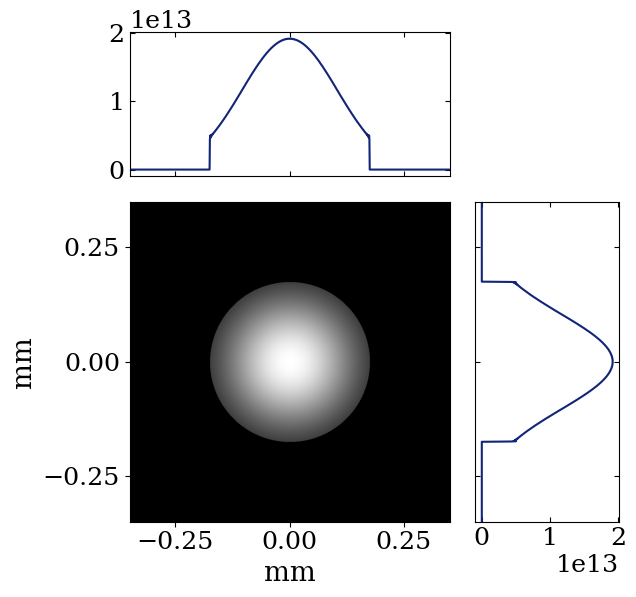

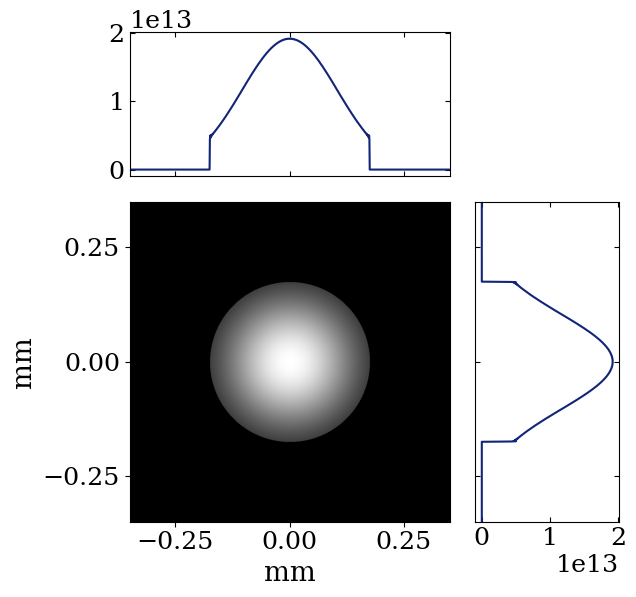

In [5]:
wfrp = deepcopy(wfr)

srw_oe_array = []
srw_pp_array = []


lens_material = 'Be'
density = xl.ElementDensity(xl.SymbolToAtomicNumber(lens_material))

n = xl.Refractive_Index(lens_material, beam_energy*1e-3, density)
delta = 1-np.real(n)
beta = np.imag(n)
att_len = wavelength /(4*np.pi*beta)

# CRl definition
R = 50e-6      # [m]
L = 1.0e-3     # lens thickness
wt = 35e-6     # wall thickness
A = 2*np.sqrt((L-wt)*R)
N = 20

CRL = srwl_opt_setup_CRL(_foc_plane=3,
                         _delta=delta,
                         _atten_len=att_len, 
                         _shape=1, 
                         _apert_h=A,
                         _apert_v=A, 
                         _r_min=R,
                         _n=N,
                         _wall_thick=wt,
                         _xc=0, 
                         _yc=0,
                         _nx=2001,
                         _ny=2001)

print('>>> %s: n = 1 - %.6e + i %.6e at %.3f keV'%(lens_material, delta, beta, beam_energy*1e-3))

# ---------- CRL aperture

Ap_CRL = SRWLOptA(_shape='c', _ap_or_ob='a', _Dx=A, _Dy=A, _x=0, _y=0)
pp = [0, 0, 1, 1, 0, 1., 5., 1., 5., 0, 0, 0]
srw_oe_array.append(Ap_CRL)
srw_pp_array.append(pp)
# ---------- CRL
pp = [0, 0, 1, 0, 0, 1., 1., 1., 1., 0, 0, 0]
srw_oe_array.append(CRL)
srw_pp_array.append(pp)

# ---------- drift to the phase-plate

oeDrift = SRWLOptD(posPP)
pp = [0, 0, 1, 1, 0, 1., 1., 1., 1., 0, 0, 0]
srw_oe_array.append(oeDrift)
srw_pp_array.append(pp)

Ap_CRL = SRWLOptA(_shape='c', _ap_or_ob='a', _Dx=350e-6, _Dy=350e-6, _x=0, _y=0)
pp = [0, 0, 1, 1, 0, 2., 1., 2., 1., 0, 0, 0]
srw_oe_array.append(Ap_CRL)
srw_pp_array.append(pp)

# pp = [0, 0, 1, 1, 0, 2., 1., 2., 1., 0, 0, 0]
# srw_pp_array.append(pp)

optBL = SRWLOptC(srw_oe_array, srw_pp_array)

print('- Simulating Electric Field Wavefront Propagation ... ')
srwl.PropagElecField(wfrp, optBL)

input_beam = deepcopy(wfrp)

wavefront_stats(wfrp)

print('>>>>> input beam')
plot_wavefront(input_beam, units='mm', phase=False, unwrap=False,
               ax_limits=[-0.35, 0.35, -0.35, 0.35], file_name='./report/input_beam')

<hr style="border:1px solid orange">

#### Beam at the image plane before tailoring:

- Simulating Electric Field Wavefront Propagation ... 

 >>> Wavefront:
Nx = 5040, Ny = 5040
dx = 0.0142 um, dy = 0.0142 um
range x = 0.0718 mm, range y = 0.0718 mm
Rx = 0.000000, Ry = 0.000000
>>>>> focused beam


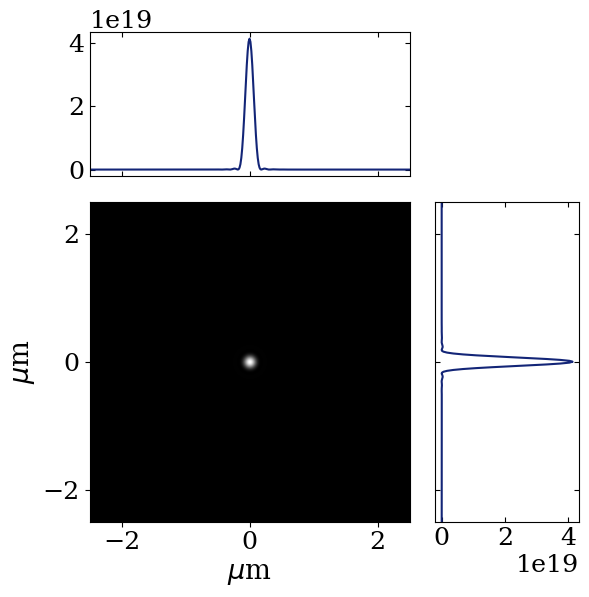

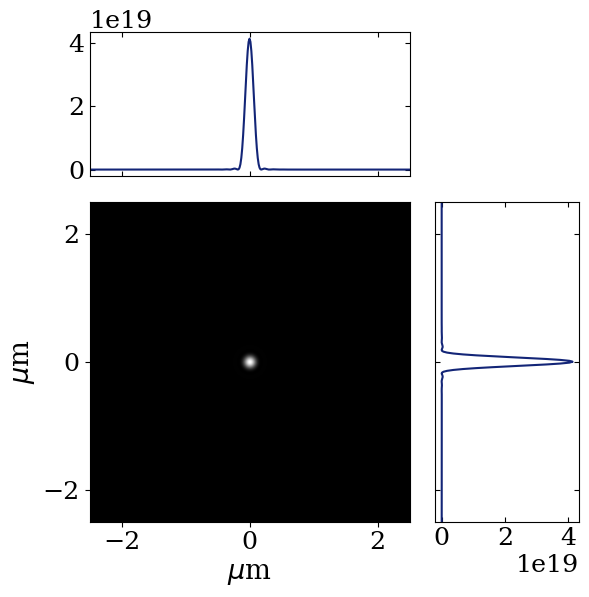

In [6]:
wfri = deepcopy(wfrp)

srw_oe_array = []
srw_pp_array = []

# ---------- drift to the image plane
pp_to_image = -(wfri.Rx + wfri.Ry)/2
oeDrift = SRWLOptD(pp_to_image)

pp = [0, 0, 1, 4, 0, 1., 1., 1., 1., 0, 0, 0]
srw_oe_array.append(oeDrift)
srw_pp_array.append(pp)

optBL = SRWLOptC(srw_oe_array, srw_pp_array)

print('- Simulating Electric Field Wavefront Propagation ... ')
srwl.PropagElecField(wfri, optBL)

focused_beam = deepcopy(wfri)

wavefront_stats(wfri)

print('>>>>> focused beam')
plot_wavefront(focused_beam, units='um', phase=False, unwrap=False,
               ax_limits=[-2.5, 2.5, -2.5, 2.5], file_name='./report/focused_beam')

<hr style="border:1px solid orange">

#### Beam tailoring algorithm:

1. [x] generation of a seed wavefront (SRWLWfr *seed_wfr*):
     - [x] definition of a function to be convolved with the focused beam intensity (SRWLWfr *focused_beam*)
        - circular uniform distribution
        - rectangular uniform distribution
        - Gaussian beam
\
&nbsp;
2. [x] back propagation of *seed_wfr* to the PP plane (SRWLWfr *propag_backward*):
   - [x] substitute the instenisy in *propag_backward* by the one from (crop/resample) SRWLWfr *input_beam* (SRWLWfr *wfr_buffer*);
\
&nbsp;
3. [x] propagation of *wfr_buffer* to the image plane (SRWLWfr *propag_foward*):
   - [x] substitute the instenisy in *propag_foward* by the one from (crop/resample) *seed_wfr* (SRWLWfr *wfr_buffer*) and update *seed_wfr*;
   - [x] go back to step #2;  
\
&nbsp;
4. [x] last back propagation of *seed_wfr* to the PP plane (SRWLWfr *propag_backward*):
   - [x] removal of the quadratic phase term from the original focusing element and cleanup of the phase for PP calculation


In [7]:
# ---------------------------------------
# Special functions ---------------------
# ---------------------------------------

def register_iteration(wavefront, propag_distance, iteration_number, wavefront_name, phase=True, unwrap=False, 
                       display=True, ax_limits=None):
    """

    :param wavefront:
    :param propag_distance:
    :param iteration_number:
    :param wavefront_name:
    :param phase:
    :param unwrap:
    :param display:
    :param ax_limits:

    :return:
    """

    if ax_limits is None:
        ax_limits = [-2.5, 2.5, -2.5, 2.5]
        
    wv = deepcopy(wavefront)

    filename = wavefront_name + '_%d_iterations' % iteration_number
    save_wft(wv, filename)

    print('> Partial result for %d-th iteration\n' % iteration_number)
    print('>>>>> focused beam')
    srw_oe_array = []
    srw_pp_array = []
    oeDrift = SRWLOptD(propag_distance)
    pp = [0, 0, 1, 4, 0, 1., 1., 1., 1., 0, 0, 0]
    srw_oe_array.append(oeDrift)
    srw_pp_array.append(pp)
    pp = [0, 0, 1, 1, 0, 0.15, 1., 0.15, 1., 0, 0, 0]
    srw_pp_array.append(pp)
    optBL = SRWLOptC(srw_oe_array, srw_pp_array)
    srwl.PropagElecField(wv, optBL)

    plot_wavefront(wv, units='um', phase=phase, unwrap=unwrap,
                   ax_limits=ax_limits, file_name=filename + '_focused_beam', display=display)


def save_wft(wavefront, wft_name):
    """

    :param wavefront:
    :param wft_name:
    :return:
    """
    if wft_name.endswith('.pickle') is False:
        wft_name += '.pickle'
    file = open(wft_name, 'wb')  # open a file, where you ant to store the data
    pickle.dump(wavefront, file)  # dump information to that file
    file.close()  # close the filebarc


def fractal_surf(sigma, exponent, PixelWidth, m, n, qr=0, seed=None):
    '''

    % Fractal topographies with different fractal dimensions.

    Adaptation of the MATLAB function 'artificial_surf' (version 1.1.0.0) by Mona Mahboob Kanafi. 
    https://www.mathworks.com/matlabcentral/fileexchange/60817-surface-generator-artificial-randomly-rough-surfaces

    parameters (in SI units)

    :param sigma: standard deviation , i.e. root-mean-square roughness Rq(m)
    :param exponent: PSD exponent = -2(H+1); Hurst exponent 0<= H <= 1, fractal dimension D = 3-H
    ::param PixelWidth: pixel size in [m]
    :param m: number of pixels in x
    :param n: number of pixels in y
    :param qr: roll-off freq. (1/m); qr > (2*pi/Lx or Ly); qr < (pi/PixelWidth) - Nyquist freq.
    :param seed: seed for random initialisaiton
    :return: surface profile and axes
    '''

    two_pi = 2 * np.pi

    # =========================================================================
    Lx = m * PixelWidth  # image length in x direction
    Ly = n * PixelWidth  # image length in y direction
    A = Lx * Ly

    qx = np.fft.fftshift(np.fft.fftfreq(m, PixelWidth))  # image frequency in fx direction
    qy = np.fft.fftshift(np.fft.fftfreq(n, PixelWidth))  # image frequency in fy direction

    Qx, Qy = np.meshgrid(qx, qy)

    # cylindrical coordinates in frequency-space
    rho = np.sqrt(Qy ** 2 + Qx ** 2)
    theta = np.arctan2(Qy, Qx)

    [y0, x0] = np.where(rho == 0)
    rho[y0, x0] = 1  # avoids division by zero

    # 2D matrix of Cq (PSD) values
    Cq = rho ** exponent
    if qr != 0:
        Cq[np.where(rho < qr)] = qr ** exponent

    Cq[y0, x0] = 0

    # =========================================================================
    # applying rms
    Cq *= (sigma / (np.sqrt(np.sum(Cq) / A))) ** 2

    # =========================================================================
    # reversing operation: PSD to fft
    Bq = np.sqrt(Cq / (PixelWidth ** 2 / ((n * m))))

    # =========================================================================
    # defining a random phase
    np.random.seed(seed)
    phi = -np.pi + (two_pi) * np.random.uniform(0, 1, (n, m))

    # =========================================================================
    # apply conjugate symmetry to magnitude and phase - inherited from Matlab
    Bq[0, 0] = 0
    Bq[0, int(m / 2)] = 0
    Bq[int(n / 2), int(m / 2)] = 0
    Bq[int(n / 2), 0] = 0
    Bq[1::, 1:int(m / 2) + 1] = np.rot90(Bq[1::, int(m / 2)::], 2)
    Bq[0, 1:int(m / 2) + 1] = np.flipud(Bq[0, int(m / 2)::])
    Bq[int(n / 2)::, 0] = np.flipud(Bq[1:int(n / 2) + 1, 0])
    Bq[int(n / 2)::, int(m / 2)] = np.flipud(Bq[1:int(n / 2) + 1, int(m / 2)])

    phi[0, 0] = 0
    phi[0, int(m / 2)] = 0
    phi[int(n / 2), int(m / 2)] = 0
    phi[int(n / 2), 0] = 0
    phi[1::, 1:int(m / 2) + 1] = -np.rot90(phi[1::, int(m / 2)::], 2)
    phi[0, 1:int(m / 2) + 1] = -np.flipud(phi[0, int(m / 2)::])
    phi[int(n / 2)::, 0] = -np.flipud(phi[1:int(n / 2) + 1, 0])
    phi[int(n / 2)::, int(m / 2)] = -np.flipud(phi[1:int(n / 2) + 1, int(m / 2)])

    # =========================================================================
    # Generates topography
    Hm = Bq * np.exp(-1j * phi)

    # phase components.
    z = np.abs(np.fft.ifftshift(np.fft.ifft2(Hm)))  # generates surface

    return z 


def average_azimuthal(_input, x_axis, y_axis):
    """

    :param _input:
    :param _center:
    :param _range_r:
    :param _delta_r:
    :param _range_theta:
    :param _delta_theta:
    :param _mask:
    :return:
    """

    def _f_xy(_theta, _rho):
        x = _rho * np.cos(_theta)
        y = _rho * np.sin(_theta)
        return x, y

    xStart = x_axis[0]
    xFin = x_axis[-1]
    nx = x_axis.size

    yStart = y_axis[0]
    yFin = y_axis[-1]
    ny = y_axis.size

    # ********************** generating auxiliary vectors
    _center = (0, 0)
    _range_r = (0, -1)
    _delta_r = 1
    _range_theta = (0, -1)
    _delta_theta = 1

    x_cen = 0.5 * (xFin + xStart)
    y_cen = 0.5 * (yFin + yStart)

    _range_r = list(_range_r)
    _range_theta = list(_range_theta)

    if _range_r[1] == -1:
        if xFin - x_cen > yFin - y_cen:
            _range_r[1] = 1 * (yFin - y_cen)
        else:
            _range_r[1] = 1 * (xFin - x_cen)

    if _range_theta[1] == -1:
        _range_theta[1] = 2 * np.pi

    nr = int(nx * _delta_r / 2)
    ntheta = int((_range_theta[1] - _range_theta[0]) * 360 * _delta_theta / 2 / np.pi)

    X = np.linspace(xStart, xFin, nx)
    Y = np.linspace(yStart, yFin, ny)

    r = np.linspace(_range_r[0], _range_r[1], nr)
    THETA = np.linspace(_range_theta[0], _range_theta[1], ntheta)

    azimuthal_average = np.zeros([nr])
    azimuthal_value = np.zeros([ntheta])

    # ********************** summation

    f = RectBivariateSpline(X, Y, _input)

    m = 0

    for rho in r:
        n = 0
        summation = 0
        for angle in THETA:
            x, y = _f_xy(angle, rho)
            azimuthal_value[n] = f(x, y)
            summation += 1
            n += 1

        azimuthal_average[m] = np.sum(azimuthal_value) / summation
        m = m + 1

    return azimuthal_average, r


def average_phase(phase, x, y):
    ph = deepcopy(phase)

    averaged_profile, r = average_azimuthal(ph, x, y)

    f_av_profile = interp1d(r, averaged_profile, bounds_error=False, fill_value=0)

    X, Y = np.meshgrid(x, y)
    R = np.sqrt(X ** 2 + Y ** 2)
    avg_profile = f_av_profile(R)

    return avg_profile


def reshufle_phase(wavefront, propag_distance, A, mthd=0, seed=None):
    wv = deepcopy(wavefront)
    wv = get_residual_wavefront(wv, propag_distance, A, propParams=None)
    phase, x, y = get_phase(wv, reshape=True)
    phase = unwrap_phase(phase)

    if mthd == 0:
        phase = average_phase(phase, x, y)
    elif mthd == 1:
        sigma = np.pi
        exponent = -3.6
        PixelWidth = x[1] - x[0]
        phase += (fractal_surf(sigma, exponent, PixelWidth, len(x), len(y), qr=0, seed=seed))

    intensity, x, y = get_intensity(wv, reshape=True)

    tailored_wavefront = np.sqrt(intensity) * np.exp(1j * phase)
    Re = np.real(tailored_wavefront)
    Im = np.imag(tailored_wavefront)

    wv.arEx[0::2] = array('f', np.reshape(Re, (wv.mesh.nx * wv.mesh.ny)))
    wv.arEx[1::2] = array('f', np.reshape(Im, (wv.mesh.nx * wv.mesh.ny)))
    wv = get_residual_wavefront(wv, -propag_distance, A, propParams=None)

    return wv


def swap_axes(wavefront):
    """

    :param wavefront:
    :return:
    """

    Dx = wavefront.mesh.xFin - wavefront.mesh.xStart

    if Dx < 0:
        wavefront.mesh.xStart *= -1
        wavefront.mesh.xFin *= -1

    Dy = wavefront.mesh.yFin - wavefront.mesh.yStart
    if Dy < 0:
        wavefront.mesh.yStart *= -1
        wavefront.mesh.yFin *= -1

    return wavefront


def swap_intensities(wavefront, reference_wavefront, register_diff=False):
    """

    :param wavefront:
    :param reference_wavefront:
    :param register_diff:
    :return:
    """

    twf = deepcopy(wavefront)

    # Checking if interpolation is needed

    Dx = wavefront.mesh.xFin - wavefront.mesh.xStart
    Dy = wavefront.mesh.yFin - wavefront.mesh.yStart

    interpol = False
    if wavefront.mesh.nx == reference_wavefront.mesh.nx:
        ref_Dx = reference_wavefront.mesh.xFin - reference_wavefront.mesh.xStart
        ref_dx = ref_Dx / (reference_wavefront.mesh.nx - 1)

        if (Dx - ref_Dx) * 1000 / ref_Dx > 1:
            print('>>>> Interpolation needed along x')
            interpol = True

    if wavefront.mesh.ny == reference_wavefront.mesh.ny:
        ref_Dy = reference_wavefront.mesh.yFin - reference_wavefront.mesh.yStart
        ref_dy = ref_Dy / (reference_wavefront.mesh.ny - 1)

        if (Dy - ref_Dy) * 1000 / ref_Dy > 1:
            print('>>>> Interpolation needed along y')
            interpol = True

    ref_intensity, x, y = get_intensity(reference_wavefront, reshape=True)
    phase, x, y = get_phase(wavefront, reshape=True)

    if register_diff:
        buf_intensity, x, y = get_intensity(wavefront, reshape=True)
        diff = 1 - np.mean(np.abs(buf_intensity - ref_intensity) / (ref_intensity + 1))
    else:
        diff = np.nan

    tailored_wavefront = np.sqrt(ref_intensity) * np.exp(1j * phase)
    Re = np.real(tailored_wavefront)
    Im = np.imag(tailored_wavefront)

    twf.arEx[0::2] = array('f', np.reshape(Re, (twf.mesh.nx * twf.mesh.ny)))
    twf.arEx[1::2] = array('f', np.reshape(Im, (twf.mesh.nx * twf.mesh.ny)))

    return twf, diff


def get_residual_wavefront(wavefront, propag_distance, A, propParams=None):
    """

    :param wavefront:
    :param propag_distance:
    :param A:
    :param propParams:
    :return:
    """

    if propParams is None:
        propParams = [1, 1, 1, 1]

    wv = deepcopy(wavefront)
    srw_oe_array = []
    srw_pp_array = []

    ideal_lens = SRWLOptL(_Fx=-propag_distance, _Fy=-propag_distance)
    pp = [0, 0, 1, 1, 0, 1., 1., 1., 1., 0, 0, 0]
    srw_oe_array.append(ideal_lens)
    srw_pp_array.append(pp)

    aperture = SRWLOptA(_shape='c', _ap_or_ob='a', _Dx=A, _Dy=A, _x=0, _y=0)
    pp = [0, 0, 1, 1, 0, propParams[0], propParams[1], propParams[2], propParams[3], 0, 0, 0]
    srw_oe_array.append(aperture)
    srw_pp_array.append(pp)

    optBL = SRWLOptC(srw_oe_array, srw_pp_array)
    srwl.PropagElecField(wv, optBL)
    wavefront_stats(wv)

    return wv


def get_wavefront_difference(wavefront, reference_wavefront):
    """

    :param wavefront:
    :param reference_wavefront:
    :return:
    """

    intensity, x, y = get_intensity(wavefront, reshape=True)
    intensity_ref, x, y = get_intensity(reference_wavefront, reshape=True)

    diff = 1 - np.mean(np.abs(intensity - intensity_ref) / (intensity_ref + 1))

    return diff


# ---------------------------------------
# Gerchberg-Saxton Algorithm ------------
# ---------------------------------------


def target_wavefront(input_wavefront, dx, dy, shape, magnification=False, phase=0):
    """
    generation of a seed/target wavefront based on the focused beam for the iterative phase-plate calculation

    :param input_wavefront: focused beam (instance of SRWLWfr)
    :param dx: desired beam width/magnification along the horizontal direction
    :param dy: desired beam width/magnification along the vertical direction
    :param shape:  'r' - rectangular, 'c' - circular, 'g' - gaussian
    :param magnification:  (bool) converts dx in Mx and dy in My
    :param phase: 0 - np.zeros; 1 - phase from input wavefront, 2 - fractal phase

    :return: SRW wavefront (instance of SRWLWfr)
    """

    def _get_mask(_image, _x, _y, _dx, _dy, _shape, _normalise=True):
        """
        ideal mask for convolution with focused beam

        :param _image: 2D numpy array to force dimensions of the mask
        :param _x: axis centred in 0 [m]
        :param _y: axis centred in 0 [m]
        :param _dx: mask width long x
        :param _dy: mask width long y
        :param _shape:  'r' - rectangular, 'c' - circular, 'g' - gaussian
        :param _normalise: (bool) integrated intensity is 1 when normalise==True

        :return: ideal mask for convolution
        """

        mask = np.ones(_image.shape)
        X, Y = np.meshgrid(np.linspace(_x[0], _x[-1], _image.shape[1]),
                           np.linspace(_y[0], _y[-1], _image.shape[0]))

        if _shape == 'r':

            mask[X < -_dx / 2] = 0
            mask[X > _dx / 2] = 0
            mask[Y < -_dy / 2] = 0
            mask[Y > _dy / 2] = 0

        elif _shape == 'c':

            yc = 0
            xc = 0
            R = ((X - xc) ** 2 + (Y - yc) ** 2) ** 0.5
            radius = np.sqrt(_dx ** 2 + _dy ** 2) / 2
            mask[R >= radius / 2] = 0

        elif _shape == 'g':
            mask = np.exp((-0.5 * (X) ** 2) / ((_dx / 2) ** 2)) * np.exp((-0.5 * (Y) ** 2) / ((_dy / 2) ** 2))

        if _normalise:
            mask /= mask.sum()

        return mask

    twf = deepcopy(input_wavefront)

    intensity, x, y = get_intensity(twf, reshape=True)

    if phase == 0:
        phase = np.zeros(intensity.shape)

    elif phase == 1:
        print('Using input wave phase for seed wavefront')
        phase, x, y = get_phase(twf, reshape=True)

    elif phase == 2:
        sigma = 2 * np.pi
        exponent = -3.6
        PixelWidth = x[1] - x[0]
        phase = (fractal_surf(sigma, exponent, PixelWidth, len(x), len(y), qr=0) - np.pi)

    fwhm_h, fwhm_v = get_fwhm(intensity, x, y)

    if magnification:
        dx *= fwhm_h
        dy *= fwhm_v

    ph, x, y = get_phase(twf, reshape=True)
    # convolution:
    product = np.fft.fft2(_get_mask(intensity, x, y, dx, dy, shape, True)) * np.fft.fft2(intensity).conj()
    conv = np.fft.fftshift(np.fft.ifft2(product))
    conv = np.real(conv)

    fwhm_hc, fwhm_vc = get_fwhm(conv, x, y)

    print('>>>> Beam magnification Mx = %.3f; My = %.3f' % (fwhm_hc / fwhm_h, fwhm_vc / fwhm_v))
    print('>>>>> focused beam: dx = %.3f um; dy = %.3f um' % (fwhm_h * 1e6, fwhm_v * 1e6))
    print('>>>>> target beam:  dx = %.3f um; dy = %.3f um' % (fwhm_hc * 1e6, fwhm_vc * 1e6))

    II_I = np.sum(intensity)
    II_T = np.sum(conv)
    conv *= II_I / II_T

    tailored_wavefront = np.sqrt(conv) * np.exp(1j * phase)

    Re = np.real(tailored_wavefront)
    Im = np.imag(tailored_wavefront)

    twf.arEx[0::2] = array('f', np.reshape(Re, (len(x) * len(y))))
    twf.arEx[1::2] = array('f', np.reshape(Im, (len(x) * len(y))))

    return twf


def f_propag_backward(input_wavefront, reference_wavefront, propag_distance, **kwargs):
    """

    :param input_wavefront:
    :param reference_wavefront:
    :param propag_distance:
    :param kwargs:
    :return:
    """

    try:
        silent = kwargs['silent']
    except:
        silent = False
    try:
        swap = kwargs['swap']
    except:
        swap = True
    try:
        register_diff = kwargs['register_diff']
    except:
        register_diff = False

    wv = deepcopy(input_wavefront)

    srw_oe_array = []
    srw_pp_array = []

    oeDrift = SRWLOptD(-propag_distance)

    pp = [0, 0, 1, 3, 0, 1., 1., 1., 1., 0, 0, 0]

    srw_oe_array.append(oeDrift)
    srw_pp_array.append(pp)
    optBL = SRWLOptC(srw_oe_array, srw_pp_array)

    if silent is False:
        print('- Simulating Electric Field Wavefront Propagation ... ')
    srwl.PropagElecField(wv, optBL)

    wv = swap_axes(wv)

    if silent is False:
        wavefront_stats(wv)

    try:  # wavefront cleanup
        A = kwargs['A']
        srw_oe_array = []
        srw_pp_array = []

        aperture = SRWLOptA(_shape='c', _ap_or_ob='a', _Dx=A, _Dy=A, _x=0, _y=0)
        pp = [0, 0, 1, 1, 0, 1., 1., 1., 1., 0, 0, 0]
        srw_oe_array.append(aperture)
        srw_pp_array.append(pp)

        optBL = SRWLOptC(srw_oe_array, srw_pp_array)
        if silent is False:
            print('>>>> wavefront cleanup')
        srwl.PropagElecField(wv, optBL)
    except:
        pass

    if swap:
        twf, diff = swap_intensities(wv, reference_wavefront, register_diff)
    else:
        twf = deepcopy(wv)
        if register_diff:
            diff = get_wavefront_difference(wv, reference_wavefront)
        else:
            diff = np.nan

    return twf, diff


def f_propag_forward(input_wavefront, reference_wavefront, propag_distance, **kwargs):
    """

    :param input_wavefront:
    :param reference_wavefront:
    :param propag_distance:
    :param kwargs:
    :return:
    """

    try:
        silent = kwargs['silent']
    except:
        silent = False
    try:
        swap = kwargs['swap']
    except:
        swap = True
    try:
        register_diff = kwargs['register_diff']
    except:
        register_diff = False

    wv = deepcopy(input_wavefront)

    srw_oe_array = []
    srw_pp_array = []

    oeDrift = SRWLOptD(propag_distance)

    pp = [0, 0, 1, 4, 0, 1., 1., 1., 1., 0, 0, 0]

    srw_oe_array.append(oeDrift)
    srw_pp_array.append(pp)
    optBL = SRWLOptC(srw_oe_array, srw_pp_array)
    if silent is False:
        print('- Simulating Electric Field Wavefront Propagation ... ')
    srwl.PropagElecField(wv, optBL)

    wv = swap_axes(wv)

    if silent is False:
        wavefront_stats(wv)

    if swap:
        twf, diff = swap_intensities(wv, reference_wavefront, register_diff)
    else:
        twf = deepcopy(wv)
        if register_diff:
            diff = get_wavefront_difference(wv, reference_wavefront)
        else:
            diff = np.nan

    return twf, diff

Using input wave phase for seed wavefront
>>>> Beam magnification Mx = 3.135; My = 3.135
>>>>> focused beam: dx = 0.188 um; dy = 0.188 um
>>>>> target beam:  dx = 0.589 um; dy = 0.589 um

>>>>> target wavefront
>>>> file gaussian_target_beam_intensity.png saved to disk.


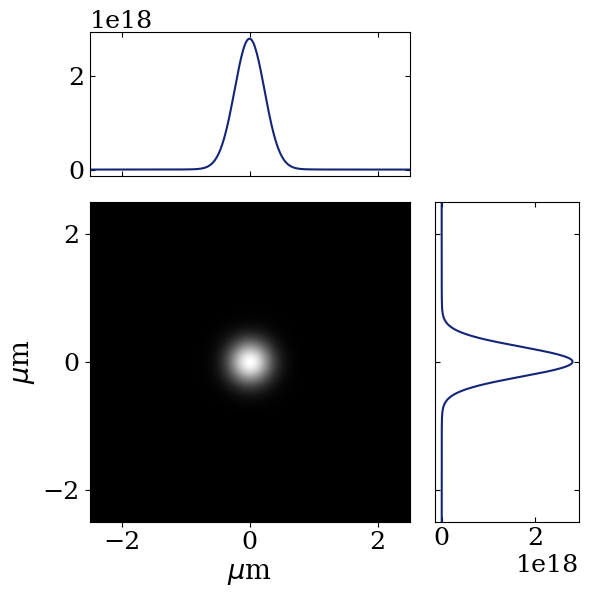

>>>> file gaussian_target_beam_phase.png saved to disk.


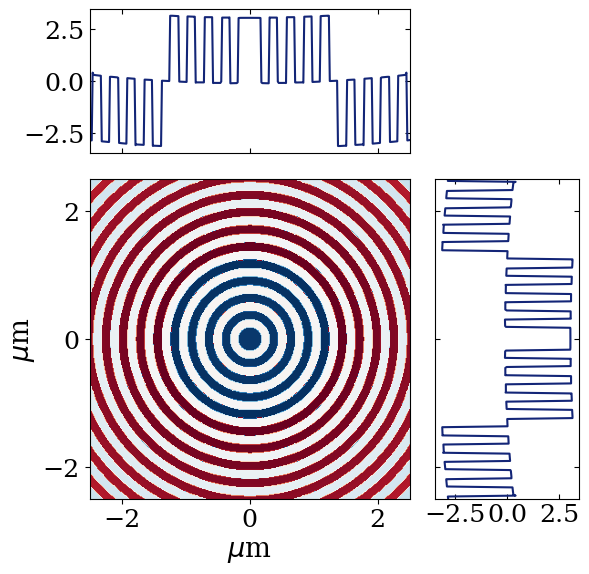

In [8]:
# STEP 1
folder = './results/'

# file_tag = 'circ'
# target_wfr = target_wavefront(focused_beam, dx=0.65e-6, dy=0.65e-6, shape='c', magnification=False, phase=1)  

# file_tag = 'rect'
# target_wfr = target_wavefront(focused_beam, dx=0.450e-6, dy=0.450e-6, shape='r', magnification=False, phase=1)  

file_tag = 'gaussian'
target_wfr = target_wavefront(focused_beam, dx=0.450e-6, dy=0.450e-6, shape='g', magnification=False, phase=1)  

print('\n>>>>> target wavefront')
plot_wavefront(target_wfr, units='um', phase=True, unwrap=False,
               ax_limits=[-2.5, 2.5, -2.5, 2.5], file_name = '%s_target_beam'%(folder+file_tag))

>>> near field prior to swapping intensities
>>>> file gaussian_NF_intensity.png saved to disk.


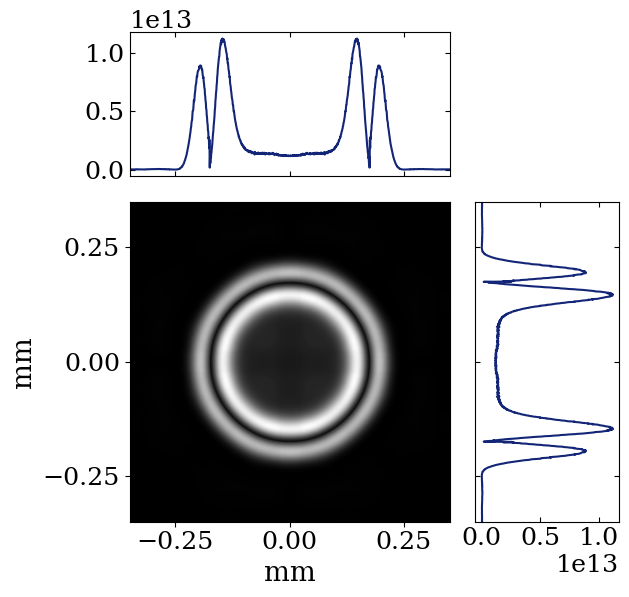

In [9]:
# STEP 2
A = 350e-6
propag_backward_wft, diff = f_propag_backward(target_wfr,
                                              input_beam,
                                              pp_to_image,
                                              #A=A,
                                              register_diff=False,
                                              swap = False,
                                              silent=True)

print('>>> near field prior to swapping intensities')
plot_wavefront(propag_backward_wft, units='mm', phase=False, unwrap=False,
               ax_limits=[-0.35, 0.35, -0.35, 0.35], file_name = '%s_NF'%(folder+file_tag))
propag_backward_wft, diff = swap_intensities(propag_backward_wft, input_beam, False)

In [10]:
# Iteration 1
vect_diff = []
vect_iter = []

n_iter = 500

for step in range(n_iter):
    
    if n_iter == step+1:
        print('last iteration')
        reswap = False
        show=True
    else:
        reswap = True
        show = False
        
    propag_forward_wft, diff = f_propag_forward(propag_backward_wft,
                                                target_wfr,
                                                pp_to_image,
                                                register_diff=True,
                                                swap = False,
                                                silent=True)
    vect_diff.append(diff)
    vect_iter.append(step+1)

    print('>>> far field (#%d)'%(step+1))
    
    if step <9:
        file_name='%siteration_000%d_%s'%(folder, step+1,file_tag)
    elif step <99:
        file_name='%siteration_00%d_%s'%(folder, step+1,file_tag)
    elif step <999:
        file_name='%siteration_0%d_%s'%(folder, step+1,file_tag)
    elif step <9999:
        file_name='%siteration_%d_%s'%(folder, step+1,file_tag)
        
#     plot_wavefront(propag_forward_wft, units='um', phase=False, unwrap=False, 
#                    ax_limits=[-2.5, 2.5, -2.5, 2.5], file_name=file_name, show=False, graph_name='iteration #%d'%(step+1))

    propag_forward_wft, diff = swap_intensities(propag_forward_wft, target_wfr, False)

    propag_backward_wft, diff = f_propag_backward(propag_forward_wft,
                                                  input_beam,
                                                  pp_to_image,
                                                  #A=A,
                                                  register_diff=False,
                                                  swap = reswap,
                                                  silent=True)

>>> far field (#1)
>>> far field (#2)
>>> far field (#3)
>>> far field (#4)
>>> far field (#5)
>>> far field (#6)
>>> far field (#7)
>>> far field (#8)
>>> far field (#9)
>>> far field (#10)
>>> far field (#11)
>>> far field (#12)
>>> far field (#13)
>>> far field (#14)
>>> far field (#15)
>>> far field (#16)
>>> far field (#17)
>>> far field (#18)
>>> far field (#19)
>>> far field (#20)
>>> far field (#21)
>>> far field (#22)
>>> far field (#23)
>>> far field (#24)
>>> far field (#25)
>>> far field (#26)
>>> far field (#27)
>>> far field (#28)
>>> far field (#29)
>>> far field (#30)
>>> far field (#31)
>>> far field (#32)
>>> far field (#33)
>>> far field (#34)
>>> far field (#35)
>>> far field (#36)
>>> far field (#37)
>>> far field (#38)
>>> far field (#39)
>>> far field (#40)
>>> far field (#41)
>>> far field (#42)
>>> far field (#43)
>>> far field (#44)
>>> far field (#45)
>>> far field (#46)
>>> far field (#47)
>>> far field (#48)
>>> far field (#49)
>>> far field (#50)
>>> far f

>>> far field (#397)
>>> far field (#398)
>>> far field (#399)
>>> far field (#400)
>>> far field (#401)
>>> far field (#402)
>>> far field (#403)
>>> far field (#404)
>>> far field (#405)
>>> far field (#406)
>>> far field (#407)
>>> far field (#408)
>>> far field (#409)
>>> far field (#410)
>>> far field (#411)
>>> far field (#412)
>>> far field (#413)
>>> far field (#414)
>>> far field (#415)
>>> far field (#416)
>>> far field (#417)
>>> far field (#418)
>>> far field (#419)
>>> far field (#420)
>>> far field (#421)
>>> far field (#422)
>>> far field (#423)
>>> far field (#424)
>>> far field (#425)
>>> far field (#426)
>>> far field (#427)
>>> far field (#428)
>>> far field (#429)
>>> far field (#430)
>>> far field (#431)
>>> far field (#432)
>>> far field (#433)
>>> far field (#434)
>>> far field (#435)
>>> far field (#436)
>>> far field (#437)
>>> far field (#438)
>>> far field (#439)
>>> far field (#440)
>>> far field (#441)
>>> far field (#442)
>>> far field (#443)
>>> far field


 >>> Wavefront:
Nx = 2520, Ny = 2520
dx = 0.3273 um, dy = 0.3273 um
range x = 0.8248 mm, range y = 0.8248 mm
Rx = 22120200047550493884416.000000, Ry = 22120200047550493884416.000000
>>>> file gaussian_residual_intensity.png saved to disk.


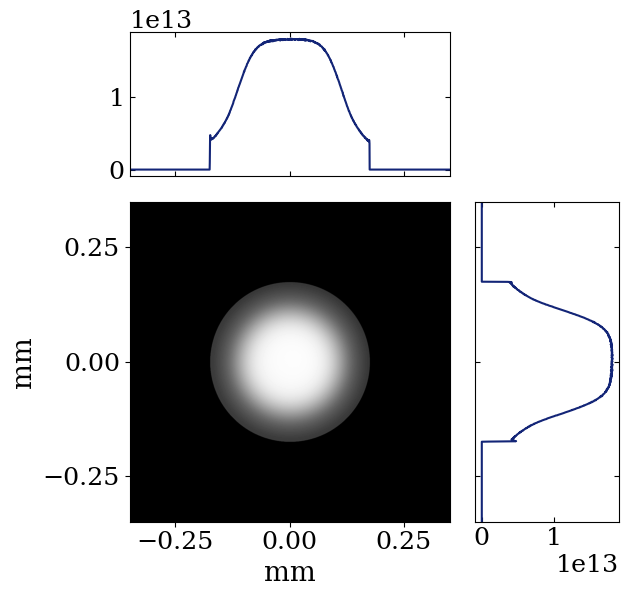

>>>> file gaussian_residual_phase.png saved to disk.


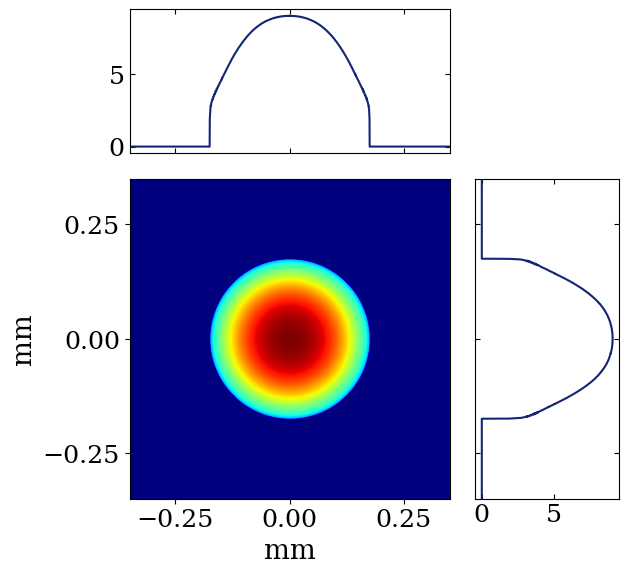

> Partial result for 500-th iteration

>>>>> focused beam
>>>> file gaussian_500_iterations_focused_beam_intensity.png saved to disk.


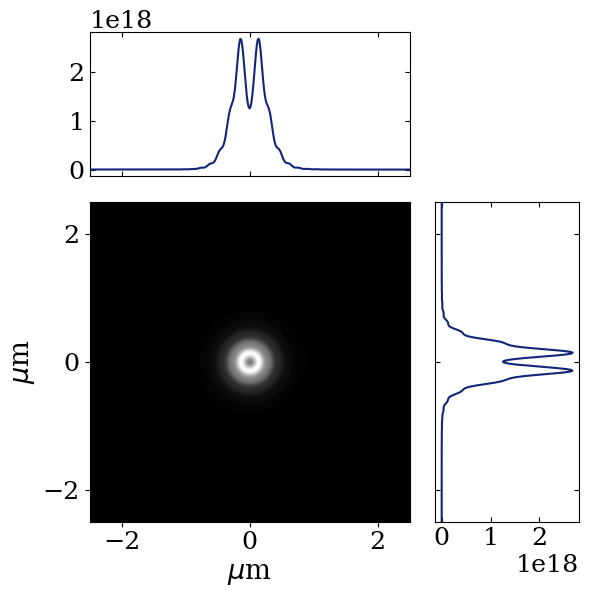

>>>> file gaussian_500_iterations_focused_beam_phase.png saved to disk.


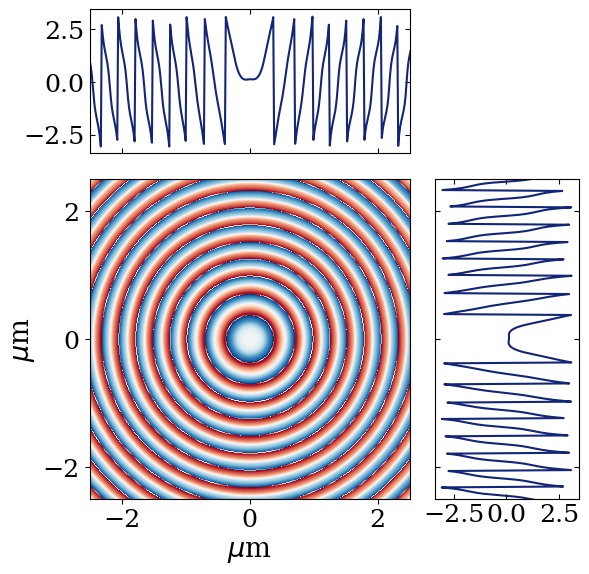

In [11]:
residual_wavefront = get_residual_wavefront(propag_backward_wft, pp_to_image, A, propParams=[0.25, 2, 0.25, 2])
plot_wavefront(residual_wavefront, units='mm', phase=True, unwrap=True,
               ax_limits=[-0.35, 0.35, -0.35, 0.35],file_name='%s_residual'%(folder+file_tag))

propag_backward_wft, diff = swap_intensities(propag_backward_wft, input_beam, False)
register_iteration(wavefront=propag_backward_wft,
                   propag_distance=pp_to_image,
                   iteration_number=n_iter, 
                   wavefront_name=file_tag)

>>>> file gaussian_progression saved to disk.


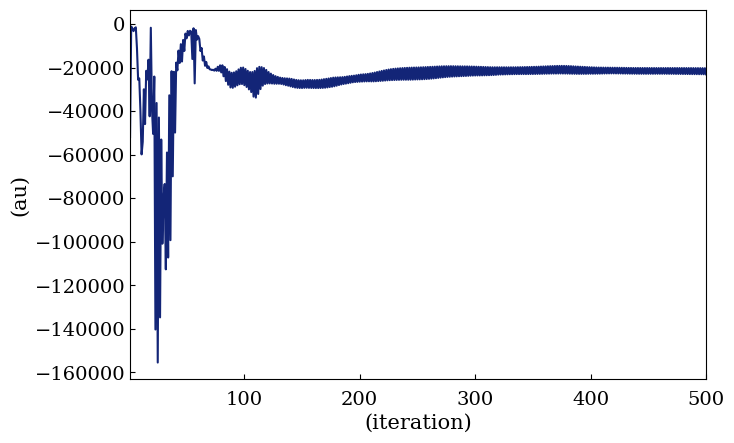

In [12]:
image = b4pt.Image2Plot(np.array(vect_diff), np.array(vect_iter))
image.legends = ['', '(iteration)', '(au)']
image.LaTex = True
image.sort_class()
b4pt.plot_1D(image, '%s_progression'%(folder+file_tag), Enable=True, Hold=False)

In [13]:
# progression = np.array([vect_iter, vect_diff])

# file = open('progression_%s.pickle'%file_tag, 'wb') 
# pickle.dump(progression, file) 
# file.close() 


In [14]:
# # Create the frames
# frames = []
# imgs = sorted(glob.glob('iteration_*.png'))
# for i in imgs:
#     new_frame = Image.open(i)
#     frames.append(new_frame)

# # Save into a GIF file that loops forever
# frames[0].save('%s.gif'%file_tag, format='GIF',
#                append_images=frames[1:],
#                save_all=True,
#                duration=100, loop=0)